In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_community.chat_models.tongyi import ChatTongyi

llm = ChatTongyi( # type: ignore
    model="qwen3-1.7b", # 这里用qwen3-0.6b似乎不支持structed_llm
    model_kwargs={
        "temperature": 0.0,
        "enable_thinking": False,
    },
)

In [2]:
from typing import Annotated, List
import operator
from pydantic import BaseModel, Field

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

编排器-工作节点工作流很常见，LangGraph 内置了对它们的支持。Send Send 允许您动态创建工作节点并向其发送特定的输入。每个工作节点都有自己的状态，所有工作节点的输出都会写入一个共享的状态键，编排器图可以访问该状态键。这使得编排器能够访问所有工作节点的输出，并将它们合成为最终输出。下面的示例遍历一个节列表，并使用 Send API 将节发送给每个工作节点。

In [3]:
from langgraph.types import Send

In [4]:
# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [5]:
from langchain.messages import SystemMessage, HumanMessage
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]



In [6]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

In [7]:
# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

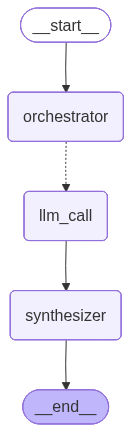

In [8]:
# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [9]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws in chinese"})

from IPython.display import Markdown
Markdown(state["final_report"])


The introduction to Large Language Models (LLMs) provides a foundational understanding of their architecture, capabilities, and the role they play in modern natural language processing. LLMs are trained on vast amounts of text data, allowing them to understand and generate human-like text across a wide range of topics and contexts. These models are typically based on transformer architectures, which enable efficient parallel processing of large volumes of data, leading to improved performance and scalability.

Scaling laws are central to the study of LLMs and their performance characteristics. These laws describe how model performance, such as accuracy, efficiency, and generalization ability, changes with increasing model size. Generally, there is a trend where larger models achieve better performance, but this improvement often plateaus after a certain point. The scaling laws also highlight the trade-offs between model size, training cost, and inference speed, offering insights into how to optimize LLMs for different applications. Understanding these laws is crucial for researchers and practitioners aiming to develop more efficient and effective large language models.

---

**Key Scaling Laws in LLMs**

Scaling laws describe how the performance and efficiency of large language models (LLMs) change with increasing model size, training data, and computational resources. These laws are critical for understanding the trade-offs involved in deploying and optimizing LLMs.

1. **Training Data Scaling**: The performance of LLMs typically scales with the amount of training data. As more data is added, the model's ability to learn complex patterns, generate coherent text, and understand context improves. This relationship is often described by the "data-hyperparameter" effect, where larger datasets lead to better generalization and reduced error rates.

2. **Model Size Scaling**: The performance of LLMs generally scales with the number of parameters in the model. Larger models have more capacity to learn intricate representations of language, leading to improved accuracy on a wide range of tasks. However, this scaling is not linear; there is a point of diminishing returns where further increases in model size do not significantly improve performance.

3. **Computational Resource Scaling**: The computational requirements for training and inference scale with the model size. Training larger models requires more memory, processing power, and time. This has led to the development of efficient training techniques, such as model parallelism, quantization, and knowledge distillation, which help reduce the computational burden while maintaining performance.

These scaling laws highlight the importance of balancing model size, training data, and computational resources to achieve optimal performance. As LLMs continue to evolve, understanding these laws will be essential for their effective deployment and optimization.

---

```markdown
# Empirical Studies on LLM Scaling

This section summarizes empirical studies and experiments that have investigated the scaling laws of Large Language Models (LLMs), highlighting trends and patterns observed in real-world applications. Key findings include:

- **Training Data and Model Performance**: Studies have shown a strong correlation between the amount of training data and model performance, with larger models generally achieving higher accuracy on tasks such as text generation, reasoning, and multi-task learning. However, the gains diminish as the model size increases beyond a certain point.

- **Parameter Count and Efficiency**: There is evidence that increasing the number of parameters in an LLM does not always lead to proportional improvements in performance. Some models exhibit diminishing returns, suggesting that efficiency in parameter usage and training cost becomes increasingly important as models grow larger.

- **Real-World Application Trends**: Empirical studies have demonstrated that while large models can outperform smaller ones on specific tasks, their performance often plateaus or declines in more complex, real-world scenarios. This suggests that the benefits of scaling may be limited by factors such as data quality, task complexity, and computational resources.

- **Generalization and Transfer Learning**: Research indicates that larger models tend to generalize better across diverse tasks, but this is often accompanied by increased computational demands and potential overfitting if not properly regularized or fine-tuned.

- **Scalability Challenges**: While scaling up models has been successful in many domains, challenges remain in maintaining performance stability, managing memory usage, and ensuring fairness and ethical considerations in large-scale deployment.

These findings underscore the importance of carefully balancing model size with practical constraints, and highlight the need for continued research into scalable architectures and efficient training methods.
```

---

**Challenges and Limitations of Scaling Laws**

Scaling laws in the context of Large Language Models (LLMs) refer to the observed relationship between model size and performance, typically expressed as $ P \propto N^\alpha $, where $ P $ is performance and $ N $ is model size. However, applying these laws to LLMs presents several challenges and limitations that hinder their effective scaling and generalization.

One major challenge is **generalization**. While larger models may perform better on training data, they often fail to generalize well to new tasks or domains. This is due to the fact that the underlying assumptions of scaling laws—such as the idea that more parameters lead to better performance—are not always valid when applied to real-world scenarios. The complexity of language and the diversity of tasks make it difficult to maintain consistent performance gains with increasing model size.

Another significant limitation is **bias**. As models are trained on large datasets, they can inadvertently inherit biases present in the data. These biases can manifest in various forms, such as skewed representations of certain groups or incorrect inferences about social issues. Scaling laws do not inherently address these biases; they focus instead on performance metrics, which can be influenced by biased data.

Additionally, **resource constraints** pose a critical challenge. Training and maintaining large LLMs require substantial computational resources, including powerful GPUs, extensive storage, and significant energy consumption. These constraints limit the practical deployment of large models, even if they show superior performance on specific tasks. The cost of scaling becomes increasingly prohibitive as model size increases, making it difficult to achieve meaningful improvements without corresponding increases in resources.

In summary, while scaling laws provide a useful framework for understanding the relationship between model size and performance, they are not without limitations. The challenges of generalization, bias, and resource constraints necessitate a more nuanced approach to model development and deployment, one that considers both technical and ethical implications.

---

**Future Directions in LLM Scaling Research**

The future of Large Language Models (LLMs) lies in the continued exploration of scaling laws and their implications for model efficiency, performance, and generalization. While current research has made significant strides in understanding how model size impacts performance, there remains a need for deeper insights into the underlying mechanisms that govern these relationships. Future research should focus on:

1. **Enhanced Understanding of Scaling Laws**: Investigating the precise relationship between model size, training data, and performance metrics, particularly in diverse tasks and domains. This includes exploring how different components of the model—such as attention mechanisms, parameter counts, and training strategies—interact with scaling behaviors.

2. **Efficient Scaling Strategies**: Developing techniques to scale models without excessive computational or memory costs. This could involve innovations in quantization, pruning, and knowledge distillation that allow for larger models to be trained and deployed more efficiently.

3. **Generalization and Robustness**: Studying how scaling affects model robustness, adaptability, and generalization across different tasks and datasets. This is crucial for ensuring that larger models maintain performance and reliability in real-world applications.

4. **Interpretable Scaling Analysis**: Creating tools and frameworks to analyze and interpret scaling patterns in a more transparent manner. This would aid in identifying which aspects of the model contribute most to performance gains and guide future design decisions.

5. **Cross-Domain and Cross-Task Scaling**: Examining how scaling laws vary across different domains (e.g., text, code, images) and tasks (e.g., reasoning, generation, translation). This will help in tailoring scaling strategies to specific use cases and environments.

6. **Long-Term Memory and Knowledge Retention**: Exploring how scaling impacts the model's ability to retain and utilize long-term memory and prior knowledge, which is critical for tasks requiring contextual understanding and reasoning.

7. **Ethical and Fairness Considerations**: Addressing the ethical implications of scaling, including bias, fairness, and the potential for unintended consequences in large models. This involves developing frameworks to ensure that scaling efforts align with ethical standards and societal needs.

By advancing these research directions, the field of LLMs can move toward more sustainable, efficient, and ethically responsible scaling strategies that maximize benefits while minimizing risks.

In [10]:
print(state["final_report"])

The introduction to Large Language Models (LLMs) provides a foundational understanding of their architecture, capabilities, and the role they play in modern natural language processing. LLMs are trained on vast amounts of text data, allowing them to understand and generate human-like text across a wide range of topics and contexts. These models are typically based on transformer architectures, which enable efficient parallel processing of large volumes of data, leading to improved performance and scalability.

Scaling laws are central to the study of LLMs and their performance characteristics. These laws describe how model performance, such as accuracy, efficiency, and generalization ability, changes with increasing model size. Generally, there is a trend where larger models achieve better performance, but this improvement often plateaus after a certain point. The scaling laws also highlight the trade-offs between model size, training cost, and inference speed, offering insights into h